In [1]:
import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io
from skimage.registration import phase_cross_correlation
from collections import defaultdict
from tqdm.notebook import trange, tqdm, tqdm_notebook
from joblib import Parallel, delayed
import re
import pickle
from matplotlib.colors import ListedColormap

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

from config import *

# Get folder info 

In [4]:
# Folder path

img_folder = r'Y:\coskun-lab\Shuangyi\IF data_antibody validation\[Revision]A549_IF validation_dilution rate test_2_9_22\A549_IF bleaching analysis_4_7_22\A549_p-AKT_CycE_ EGFR_40x_4_7_22'
aft_folder = r'Y:\coskun-lab\Shuangyi\IF data_antibody validation\[Revision]A549_IF validation_dilution rate test_2_9_22\A549_IF bleaching analysis_4_7_22\A549_AfterBleach_40x_4_7_22'
before_folder = r'Y:\coskun-lab\Shuangyi\IF data_antibody validation\[Revision]A549_IF validation_dilution rate test_2_9_22\A549_IF bleaching analysis_4_7_22\A549_DAPI only_40x_4_7_22'

In [5]:
channel2marker = {
    "CH1": "Hoeschst", 
    "CH2": "p-AKT",
    "CH3": "Cyclin E",
    "CH4": "EGFR"
}

def get_info(img_folder, name_dict=channel2marker, save=False):
    """Function returns the info from folder containing multi-cycle staigning on cell

    Args:
        img_folder (str) : imgage folder path to get information
        name_dict (dict) : three level dictionnary mapping cycle -> channel -> marker name

    Returns:
        pandas dataframe with information
    """
    locations = []
    cycles = []
    z_stacks = []
    channels = []
    images_path = []
    markers = []

    # Loop through image folder
    for (dirpath, dirnames, filenames) in os.walk(img_folder):
        for name in sorted(filenames):

            if "tif" in name and "Overlay" not in name and "stitched" not in name and 'Composite' not in name:
                # Get information from image name

                z_stack = name.split("_")[2][1:]
                location = name.split("_")[1]
                channel = name.split("_")[-1].split(".")[0]

                if z_stack == "":
                    continue

                marker = name_dict[channel]

                locations.append(int(location))
                z_stacks.append(int(z_stack[1:]))
                channels.append(channel)
                markers.append(marker)
                images_path.append(os.path.join(dirpath, name))
    info = {
        "Location": locations,
        "Z_stack": z_stacks,
        "Channel": channels,
        "Marker": markers,
        "Path": images_path,
    }
    df = pd.DataFrame(info)

    if save == True:
        df.to_csv(data_meta / "info.csv", index=False)

    df.Z_stack = pd.to_numeric(df.Z_stack)

    return df

In [6]:
df = get_info(img_folder)
df['Condition'] = 'Stained'
df_aft = get_info(aft_folder)
df_aft['Condition'] = 'After Bleach'
df_bfr = get_info(before_folder)
df_bfr['Condition'] = 'Before'

In [7]:
df_all = pd.concat([df, df_aft, df_bfr])

# Find best focus

In [8]:
from skimage import exposure

def blur_score(img):
    fm = cv2.Laplacian(img, cv2.CV_64F).var()
    return fm

def detect_blur_fft(image, size=60):
    # grab the dimensions of the image and use the dimensions to
    # derive the center (x, y)-coordinates
    (h, w) = image.shape
    (cX, cY) = (int(w / 2.0), int(h / 2.0))
    
    # compute the FFT to find the frequency transform, then shift
    # the zero frequency component (i.e., DC component located at
    # the top-left corner) to the center where it will be more
    # easy to analyze
    fft = np.fft.fft2(image)
    fftShift = np.fft.fftshift(fft)
    
    # zero-out the center of the FFT shift (i.e., remove low
    # frequencies), apply the inverse shift such that the DC
    # component once again becomes the top-left, and then apply
    # the inverse FFT
    fftShift[cY - size:cY + size, cX - size:cX + size] = 0
    fftShift = np.fft.ifftshift(fftShift)
    recon = np.fft.ifft2(fftShift)
    
    magnitude = 20 * np.log(np.abs(recon))
    mean = np.mean(magnitude)
    
    return mean

def read_img(path):
    return skimage.io.imread(path)

def contrast_streching(img):
    p2, p98 = np.percentile(img, (0.5, 99.5))
    return exposure.rescale_intensity(img, in_range=(p2, p98), out_range=(0,1))

def joblib_loop(task, pics):
    return Parallel(n_jobs=20)(delayed(task)(i) for i in pics)

In [9]:
df_subset = df_all[df_all.Channel == 'CH1']
grouped = df_subset.groupby(['Location', 'Condition'])
max_blur_values = []

for name, group in tqdm(grouped):
    paths = group.Path.tolist()
    imgs = joblib_loop(read_img, paths)
    blur_scores = joblib_loop(detect_blur_fft, imgs)
    blur_max = np.argmax(blur_scores)
    values = list(name)
    values.append(blur_max)
    max_blur_values.append(values)

df_blur_max = pd.DataFrame(max_blur_values, columns=['Location', 'Condition', 'Z_stack_focus'])


  0%|          | 0/27 [00:00<?, ?it/s]

In [10]:
df_blur_max

,Location,Condition,Z_stack_focus
0,1,After Bleach,10
1,1,Before,12
2,1,Stained,14
3,2,After Bleach,11
4,2,Before,13
5,2,Stained,15
6,3,After Bleach,10
7,3,Before,11
8,3,Stained,13
9,4,After Bleach,10


# Check bleaching

In [11]:
def background_correction(
    img, filtersize=1025, sigma=256
):
    """Function to perform background substraction for image using gaussian blurr of original image

    Args:
        df (pd DataFrame) : info dataframe for all images
        filtersize (int) : filter size of gaussian kernel
        sigma (int) : sigma of guassian blurr
        folder (str) : folder to save corrected images
        save (bool) : bool to save the image
        show (bool) : bool to show corrected image and gaussian blur of original image

    Returns:
        None
    """

    gaussianImg = cv2.GaussianBlur(img, (filtersize, filtersize), sigma)
    img_corrected = cv2.subtract(img, gaussianImg)
    return img_corrected

In [12]:
grouped = df_all.groupby(['Location', 'Condition'])
df_z = []

for name, group in tqdm(grouped):
    z = df_blur_max[(df_blur_max.Location == name[0]) & (df_blur_max.Condition == name[1])].Z_stack_focus.item()
    group_z = group[group.Z_stack == z]
    df_z.append(group_z)

  0%|          | 0/27 [00:00<?, ?it/s]

In [13]:
df_best_focus = pd.concat(df_z)

In [14]:
grouped = df_best_focus.groupby(['Location'])
intensities = []
for name, group in tqdm(grouped):
    # Get images
    paths = group.Path.tolist()
    markers = group.Marker.tolist()
    conditions = group.Condition.tolist()
    imgs = joblib_loop(read_img, paths)
    imgs = joblib_loop(background_correction, imgs)
    imgs = np.stack(imgs)
    
    # Get mask
    imgs_stained = imgs[-4:]
    img_masks = []
    for img in imgs_stained:
        img = contrast_streching(img)
        img_masks.append(img)
    img_seg = np.max(img_masks, axis=0)
    img_seg = cv2.GaussianBlur(img_seg, (5,5), cv2.BORDER_DEFAULT)
    img_seg = img_seg>0.35
    
    #
    img_seg_3D = np.broadcast_to(img_seg, imgs.shape)
    imgs_filtered = np.where(img_seg_3D, imgs, 0)
    intensity_sum = np.mean(imgs_filtered, axis=(1,2))
    df_intensity = pd.DataFrame(intensity_sum, columns=['Intensity'])
    df_intensity['Marker'] = markers
    df_intensity['Condition'] = conditions
    intensities.append(df_intensity)


  0%|          | 0/9 [00:00<?, ?it/s]

In [15]:
df_intensity = pd.concat(intensities)
df_intensity = df_intensity[df_intensity.Marker != 'Hoeschst']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Cyclin E_Stained vs. Cyclin E_After Bleach: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.711e-03 U_stat=8.100e+01
EGFR_Stained vs. EGFR_After Bleach: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.711e-03 U_stat=8.100e+01
EGFR_Before vs. EGFR_Stained: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.711e-03 U_stat=0.000e+00
p-AKT_Stained vs. p-AKT_After Bleach: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.711e-03 U_stat=8.100e+01
p-AKT_Before vs. p-AKT_Stained: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.711e-03 U_stat=0.000e+00
Cyclin E_Before vs. Cyclin E_Stained: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.711e-03 U_stat=0.000e+00
EGFR_Before v

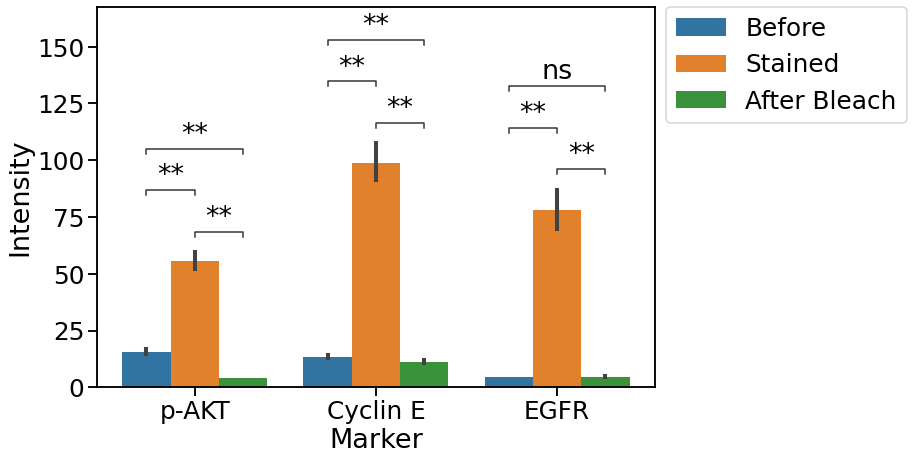

In [17]:
import seaborn as sns
from statannotations.Annotator import Annotator
sns.set_context("talk", font_scale=1.5)

fig, ax = plt.subplots(figsize=(10,7))
g = sns.barplot(x="Marker", y="Intensity", hue="Condition",
                    data=df_intensity, ax=ax, hue_order=['Before', 'Stained', 'After Bleach'])

pairs = [((marker, 'Stained'), (marker, 'After Bleach')) for marker in df_intensity.Marker.unique()]
pairs += [((marker, 'Before'), (marker, 'After Bleach')) for marker in df_intensity.Marker.unique()]
pairs += [((marker, 'Before'), (marker, 'Stained')) for marker in df_intensity.Marker.unique()]
annot = Annotator(g, pairs, data=df_intensity, x="Marker", y="Intensity", hue="Condition", hue_order=['Before', 'Stained', 'After Bleach'])
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2, comparisons_correction="Bonferroni")
annot.apply_test()
ax, test_results = annot.annotate()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)